In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#ignoring all warnings
import warnings
warnings.filterwarnings('ignore')

import shap

# load JS visualization code to notebook. Without this, the SHAP plots won't be displayed
shap.initjs()

In [2]:
#getting the data and labels from the dataset
data, labels = shap.datasets.adult(display=True)

#storing the labels as an numpy array
labels = np.array([int(label) for label in labels])

print(data.shape, labels.shape)
data.head()

(32561, 12) (32561,)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [3]:
#seeing the distribution of class labels
pd.Series(labels).value_counts()

0    24720
1     7841
dtype: int64

## Basic Feature Engineering
Here we convert the categorical columns with string values to numeric representations. Typically the XGBoost model can handle categorical data natively being a tree-based model so we don’t one-hot encode the features here.




In [4]:
cat_cols = data.select_dtypes(['category']).columns # Storing names of all categorical columns in cat_cols
cat_cols

Index(['Workclass', 'Marital Status', 'Occupation', 'Relationship', 'Race',
       'Sex', 'Country'],
      dtype='object')

In [5]:
cat_cols[0]

'Workclass'

In [6]:
data[cat_cols[0]]

0                State-gov
1         Self-emp-not-inc
2                  Private
3                  Private
4                  Private
               ...        
32556              Private
32557              Private
32558              Private
32559              Private
32560         Self-emp-inc
Name: Workclass, Length: 32561, dtype: category
Categories (9, object): [?, Federal-gov, Local-gov, Never-worked, ..., Self-emp-inc, Self-emp-not-inc, State-gov, Without-pay]

In [7]:
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes) # Converting the categorical columns into numerical columns
data.head()

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,0,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,1,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,0,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


## Building Train and Test Datasets

We will maintain two datasets:

One with the encoded categorical values will be used for training our model. (X_train, X_test, y_train, y_test)
One with the original values will be used for model interpretation since we'll be able to see actual values and not encoded values on the graphs. (X_train_disp, X_test_disp, y_train_disp, y_test_disp)

### Processed Dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
X_train.head()

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,6,9.0,2,5,5,4,0,0.0,2179.0,12.0,39
1216,48.0,6,10.0,2,3,0,0,1,7688.0,0.0,40.0,39
27962,23.0,7,10.0,2,10,0,4,1,0.0,0.0,30.0,39
23077,56.0,2,9.0,0,4,1,4,0,0.0,0.0,40.0,39
10180,17.0,4,7.0,4,9,3,4,0,0.0,0.0,9.0,39


### Raw Dataset

In [9]:
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)
print(X_train_disp.shape, X_test_disp.shape)
X_train_disp.head(3)

(22792, 12) (9769, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
19749,34.0,Self-emp-not-inc,9.0,Married-civ-spouse,Farming-fishing,Wife,White,Female,0.0,2179.0,12.0,United-States
1216,48.0,Self-emp-not-inc,10.0,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,7688.0,0.0,40.0,United-States
27962,23.0,State-gov,10.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,30.0,United-States


### Building and Training the classification model

In [10]:
import xgboost as xgb #importing xgboost model from xgb library
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, random_state=42) # Creating a XGB Classifier

In [11]:
xgc.fit(X_train, y_train) # Training the model with fit method

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [12]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])

### Performance Evaluation

In [13]:
accuracy_score(y_test, predictions)

0.8712253045347528

# Diving into SHAP
The really awesome aspect about this framework is while SHAP values can explain the output of any machine learning model, for really complex ensemble models it can be slow. But they have developed a high-speed exact algorithm for tree ensemble methods. Fast C++ implementations are supported for XGBoost, LightGBM, CatBoost, and scikit-learn tree models!

SHAP (SHapley Additive exPlanations) assigns each feature an importance value for a particular prediction. 

Its novel components include: 
* the identification of a new class of additive feature importance measures
* theoretical results showing there is a unique solution in this class with a set of desirable properties. 

Typically, SHAP values try to explain the output of a model (function) as a sum of the effects of each feature being introduced into a conditional expectation. Importantly, for non-linear functions the order in which features are introduced matters. The SHAP values result from averaging over all possible orderings. Proofs from game theory show this is the only possible consistent approach.

In [14]:
# creating an explainer for our model
explainer = shap.TreeExplainer(xgc)

# finding out the shap values using the explainer
shap_values = explainer.shap_values(X_test)

In [15]:
# Expected/Base/Reference value = the value that would be predicted if we didn’t know any features of the current output”
print('Expected Value:', explainer.expected_value)

Expected Value: -1.3625857


In [16]:
# displaying the first 5 rows of the shap values table
pd.DataFrame(shap_values).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.209206,-0.003895,-0.073927,-1.078541,-0.645259,-0.517731,-0.002871,-0.421329,-0.144742,-0.036394,-0.568053,-0.004587
1,0.354368,-0.262398,-0.483883,0.586233,0.307967,1.194750,0.017408,-0.216272,-0.108322,-0.048158,-0.095782,0.017657
2,-0.525650,0.030637,0.970991,0.360480,0.528695,0.603971,-0.103895,0.050630,-0.176231,-0.087669,0.509656,0.024573
3,-0.426095,0.076188,0.576406,-1.108961,-0.517884,-0.522604,0.028896,-0.359870,-0.142805,-0.057430,-0.250736,0.023183
4,-0.503867,-0.159754,-0.129339,-0.547773,-0.049194,-0.414065,-0.019701,0.128197,-3.685364,-0.031033,0.781617,0.001285


## Feature Importances with SHAP
### Summary Plot
This basically takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

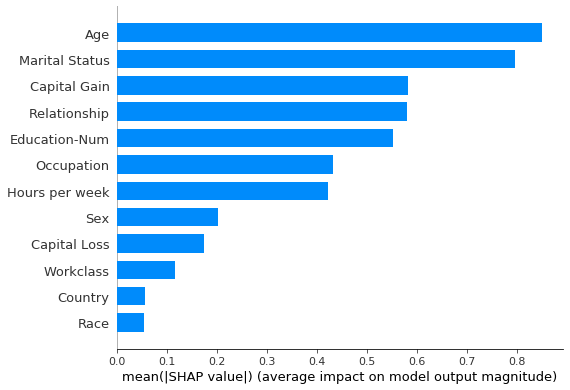

In [17]:
shap.initjs()
shap.summary_plot(shap_values, 
                  X_test, plot_type="bar")

## SHAP Summary Plot

Besides a typical feature importance bar chart, SHAP also enables us to use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset.

Features are sorted by the sum of the SHAP value magnitudes across all samples.

Note that when the scatter points don’t fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

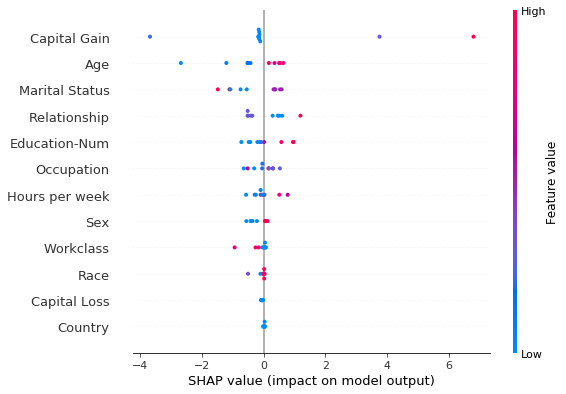

In [18]:
shap.initjs()
shap.summary_plot(shap_values[:10], X_test[:10])

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single (or two) feature across the whole dataset.

They plot a feature’s value vs. the SHAP value of that feature across many samples.

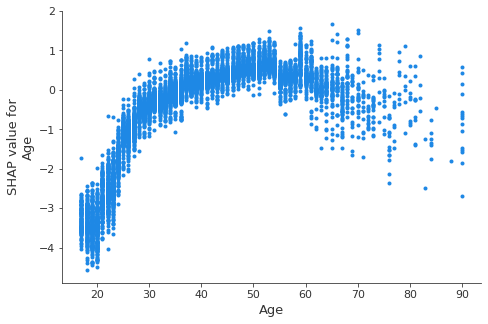

In [19]:
shap.dependence_plot(ind='Age',interaction_index=None,shap_values=shap_values, features=X_test)

Just like we observed before. the middle-aged people have a slightly higher shap value, pushing the model’s prediction decisions to say that these individuals make more money as compared to younger or older people

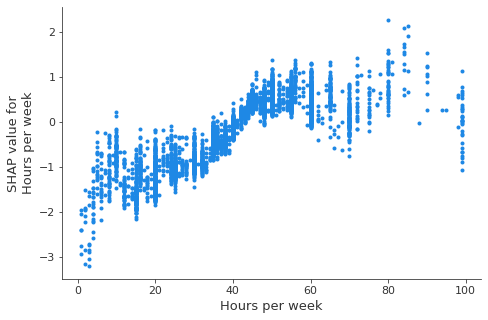

In [20]:
shap.dependence_plot(ind='Hours per week',interaction_index=None,shap_values=shap_values, features=X_test)

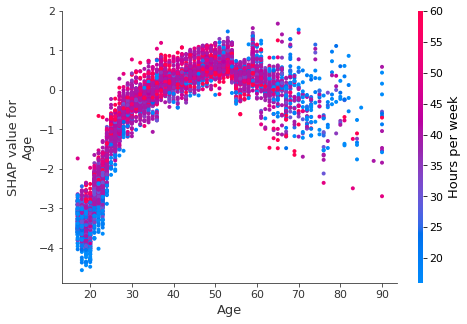

In [21]:
shap.dependence_plot(ind='Age',interaction_index='Hours per week',shap_values=shap_values, features=X_test)

## Force Plot

In [22]:
X_test_disp.iloc[2,:]

Age                                29
Workclass                     Private
Education-Num                      13
Marital Status     Married-civ-spouse
Occupation            Exec-managerial
Relationship                  Husband
Race                            Black
Sex                              Male
Capital Gain                        0
Capital Loss                        0
Hours per week                     55
Country                 United-States
Name: 28868, dtype: object

In [23]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[2,:], X_test_disp.iloc[2,:],link='logit')

In [24]:
X_test_disp.iloc[11,:]

Age                               37
Workclass                    Private
Education-Num                      9
Marital Status              Divorced
Occupation         Handlers-cleaners
Relationship           Not-in-family
Race                           White
Sex                             Male
Capital Gain                       0
Capital Loss                       0
Hours per week                    40
Country                United-States
Name: 31900, dtype: object

In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[11,:], X_test_disp.iloc[11,:],link='logit')

In [26]:
#without link logit
shap.initjs()
shap.force_plot(explainer.expected_value, 
                shap_values[11,:], X_test_disp.iloc[11,:])